# LSTM Model Comparison With Data From Different Domains

In [1]:
import sys
import os

%matplotlib inline

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.DL_LSTM import run_lstm_on_dataset, build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions, log_system_usage

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2
from src.visualization.visualization import plot_heatmap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

#### Multivariate Input Single Output

In [3]:
finance_data_no_lag = pd.read_csv('../data/dataset_finance/processed/processed_finance_data_no_lag.csv')

finance_data_no_lag

,Date,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_day,TSLA_month,TSLA_weekday,day_sin,day_cos,month_sin,...,Close_SOXX,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University_of_Michigan-Consumer_Sentiment,Consumer_Price_Index-All_Items-Total_for_United_States,Total_Vehicle_Sales
0,2014-09-17,17.425333,77665500.0,0.002454,17.0,9.0,2.0,-0.299363,-0.954139,-1.000000,...,26.093210,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959
1,2014-09-18,17.587999,55389000.0,0.009335,18.0,9.0,3.0,-0.485302,-0.874347,-1.000000,...,26.492056,355500.0,0.015285,97.413,96.013,2.63,0.09,84.6,0.075257,16.959
2,2014-09-19,17.288000,102163500.0,-0.017057,19.0,9.0,4.0,-0.651372,-0.758758,-1.000000,...,26.161163,339000.0,-0.012490,97.413,96.013,2.59,0.09,84.6,0.075257,16.959
3,2014-09-22,16.668667,123211500.0,-0.035824,22.0,9.0,0.0,-0.968077,-0.250653,-1.000000,...,25.845039,315600.0,-0.012084,97.413,96.013,2.57,0.09,84.6,0.075257,16.959
4,2014-09-23,16.694000,84880500.0,0.001520,23.0,9.0,1.0,-0.998717,-0.050649,-1.000000,...,25.762320,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,199.399994,111747100.0,0.038704,26.0,2.0,0.0,-0.848644,0.528964,0.866025,...,212.632172,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177
2374,2024-02-27,199.729996,108645400.0,0.001655,27.0,2.0,1.0,-0.724793,0.688967,0.866025,...,212.420441,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177
2375,2024-02-28,202.039993,99806200.0,0.011566,28.0,2.0,2.0,-0.571268,0.820763,0.866025,...,210.031952,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177
2376,2024-02-29,201.880005,85907000.0,-0.000792,29.0,2.0,3.0,-0.394356,0.918958,0.866025,...,215.721985,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177


[Before Training] Memory Usage: 482.82 MB | Peak Memory Usage: 507.08 MB | CPU Usage: 0.00%
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9745e-04 - val_loss: 0.0038
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.5334e-04 - val_loss: 0.0032
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3766e-04 - val_loss: 0.0032
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.7941e-04 - val_loss: 0.0039
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4955e-04 - val_loss: 0.0038
[After Training] Memory Usage: 543.23 MB | Peak Memory Usage: 565.74 MB | CPU Usage: 1.60%
Total Training Time: 10.57 seconds
Memory Used (MB): 60.41
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


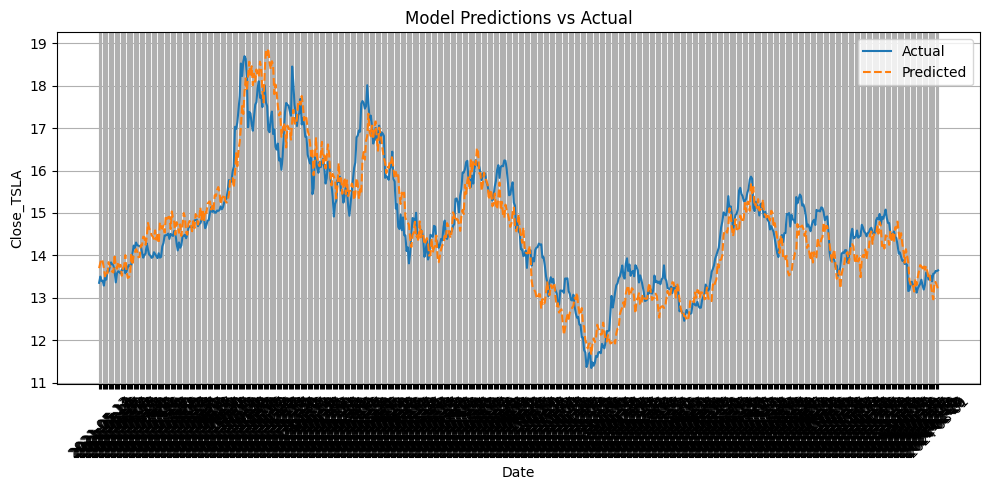


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                     0.549
MSE                      0.302
MAE                      0.426
MAPE (%)                 2.870
R²                       0.847
Adj R²                   0.832
Training Time (s)          10.57
Memory Usage (MB)         564.21
Peak Memory (MB)         567.68
CPU Usage (%)            30.10
Device Used                CPU
---------------------------------------------------------------------------


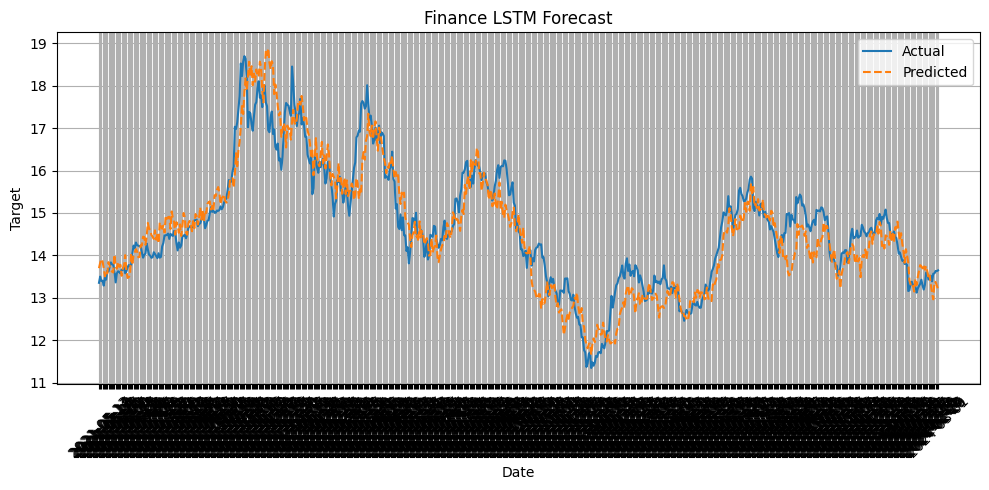

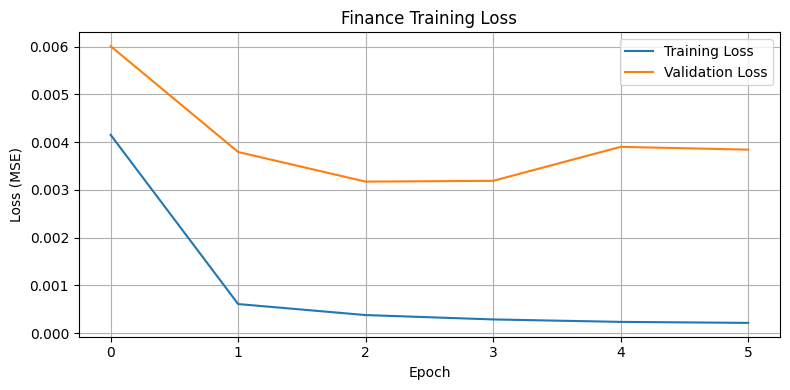

{'Dataset': 'Finance',
 'RMSE': 0.5493053792129603,
 'MSE': 0.30173639963229415,
 'MAE': 0.4257299575721984,
 'MAPE': 2.8701678637317745,
 'R²': 0.8468687802805006,
 'Adj_R²': 0.8318184419929366,
 'TrainingTime': 10.572093963623047,
 'Device': 'CPU',
 'FinalMemoryMB': 564.0859375,
 'PeakMemoryMB': 567.67578125,
 'CPUUsage': 14.4,
 'TrainingLoss': 0.00021352461772039533,
 'Model': 'LSTM'}

In [4]:
# Run LSTM Model on Finance Data

# Define parameters for LSTM model
target = 'Close_TSLA'  # Target variable to predict
date_col = 'Date'  # Column name for the date
data = finance_data_no_lag
data.name = "Finance"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

finance_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
finance_results


In [10]:
# load parquet data to pandas dataframe
retail_data_no_lag = pd.read_parquet('../data/dataset_retail/processed/data_no_lags_s1_i1.parquet')
retail_data_no_lag	= retail_data_no_lag.drop(columns=['split'])

retail_data_no_lag

,date,sales,year,month,day,dayofweek,dayofyear,weekofyear,quarter,is_month_start,is_month_end
0,2013-01-01,13,2013,1,1,1,1,1,1,1,0
1,2013-01-02,11,2013,1,2,2,2,1,1,0,0
2,2013-01-03,14,2013,1,3,3,3,1,1,0,0
3,2013-01-04,13,2013,1,4,4,4,1,1,0,0
4,2013-01-05,10,2013,1,5,5,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,14,2017,12,27,2,361,52,4,0,0
1822,2017-12-28,19,2017,12,28,3,362,52,4,0,0
1823,2017-12-29,15,2017,12,29,4,363,52,4,0,0
1824,2017-12-30,27,2017,12,30,5,364,52,4,0,0


[Before Training] Memory Usage: 1290.31 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0409 - val_loss: 0.0245
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0173 - val_loss: 0.0213
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0151 - val_loss: 0.0215
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0140 - val_loss: 0.0207
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0133 - val_loss: 0.0189
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0129 - val_loss: 0.0184
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0122 - val_loss: 0.0188
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0116 - val_loss: 0.0182
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0113 - val_loss: 0.0179
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0110 - val_loss: 0.0177
[After Training] Memory Usage: 1331.50 MB | Peak Memory

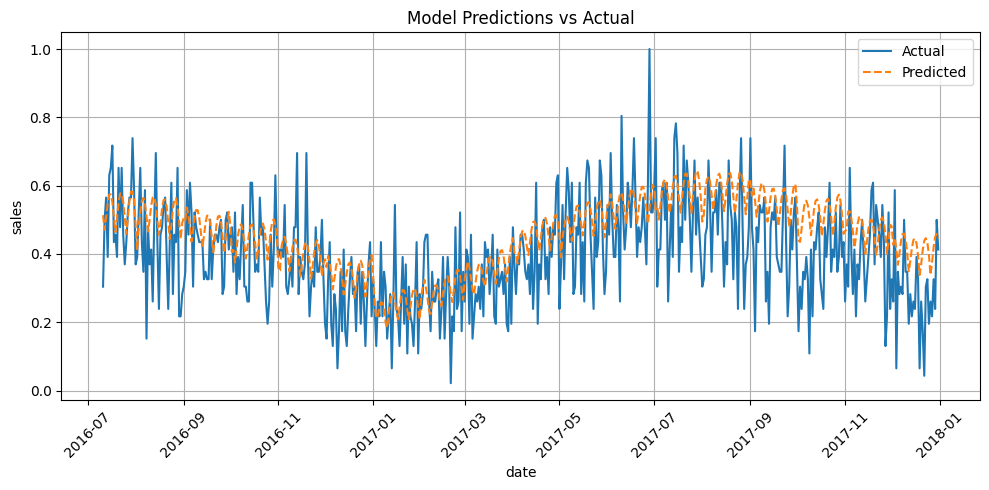


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                     0.133
MSE                      0.018
MAE                      0.107
MAPE (%)                41.024
R²                       0.170
Adj R²                   0.156
Training Time (s)          14.62
Memory Usage (MB)        1335.79
Peak Memory (MB)        3888.91
CPU Usage (%)            23.80
Device Used                CPU
---------------------------------------------------------------------------


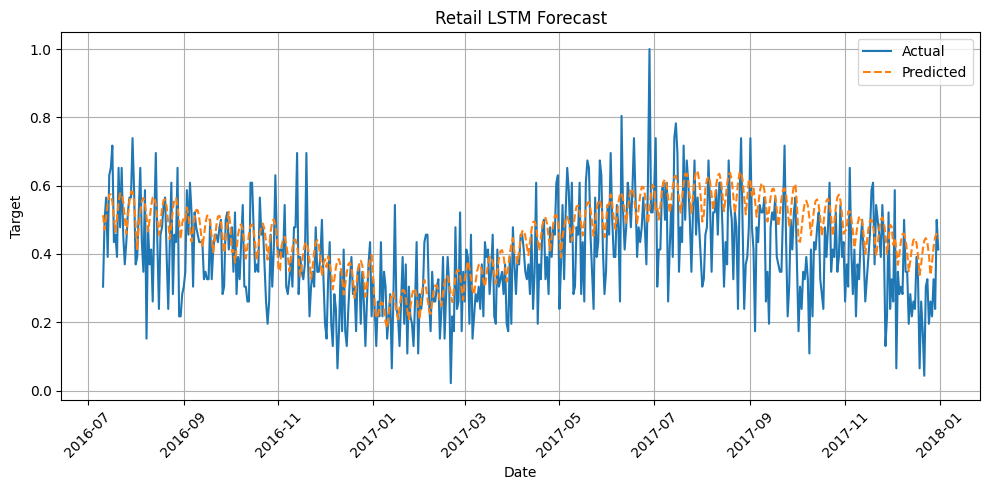

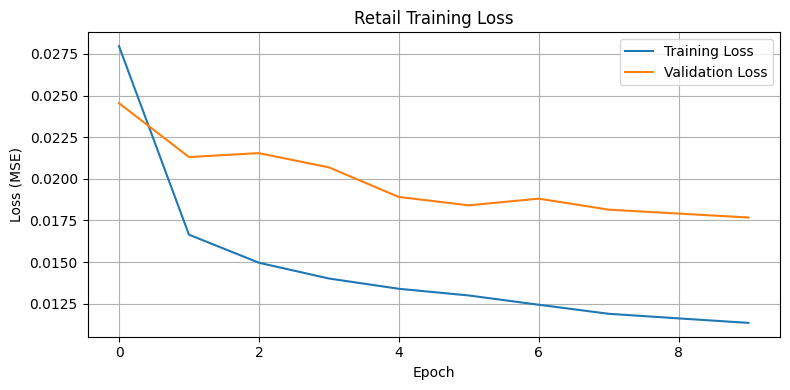

{'Dataset': 'Retail',
 'RMSE': 0.13296238923085216,
 'MSE': 0.01767899694997663,
 'MAE': 0.10701151285944058,
 'MAPE': 41.02407906800946,
 'R²': 0.17009750250541578,
 'Adj_R²': 0.15597817835144367,
 'TrainingTime': 14.621217727661133,
 'Device': 'CPU',
 'FinalMemoryMB': 1335.8046875,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 18.5,
 'TrainingLoss': 0.01135468389838934,
 'Model': 'LSTM'}

In [11]:
# Run LSTM Model on Retail Data

# Define parameters for LSTM model
data = retail_data_no_lag
retail_data_no_lag.name = "Retail"
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

retail_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
retail_results

In [17]:
transportation_data_no_lag = pd.read_csv('../data/dataset_transport/Baltimore.csv')
# transportation_data_no_lag['Month'] = transportation_data_no_lag['Month'].dt.strftime('%Y%m').astype(int)

transportation_data_no_lag

,Month,Container Tons,Auto Tons,Ro/Ro Tons (excl. autos),Forest Products (Break Bulk),Steel & other metals Break Bulk Tons,other Break Bulk Tons,Total General Cargo Tons,Import Loaded TEUs,Export Loaded TEUs,...,Import Empty TEUs,Export Empty TEUs,Total Empty TEUs,Total TEUs,Total Containers,Import Auto Units,Export Auto Units,Total Auto UNITS,Import Ro/Ro Tons,Export Ro/Ro Tons
0,Jan-98,360095,18386,32967,54189,15705,27515,508857,16051,17418,...,3199,1436,4635,38104,23789,9452,2391,11843,22160,10807
1,Feb-98,359722,20085,37156,42726,13805,31879,505373,16228,16846,...,3045,2056,5101,38175,23874,11206,1393,12599,23405,13751
2,Mar-98,377748,27610,57077,43910,10344,31001,547690,18577,18570,...,5906,3525,9431,46578,28926,14570,2967,17537,40470,16607
3,Apr-98,377397,21900,56087,48180,5663,33094,542321,17777,18157,...,2712,3070,5769,41703,25985,11715,2342,14057,39312,16775
4,May-98,382760,25824,40905,25530,4022,37509,516550,18178,17104,...,2407,3242,5626,40908,26250,15081,1790,16871,28865,12040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Sep-24,600022,86008,66156,62312,1258,13768,829524,42751,13643,...,211,27538,27749,84143,49289,34044,6967,41011,46829,19327
321,Oct-24,526700,72803,56889,23489,417,7200,687498,37221,12053,...,94,22839,22933,72207,42427,21364,9838,31202,45205,11684
322,Nov-24,719903,112552,84434,71229,902,17902,1006922,44375,21030,...,83,20478,20561,85966,50420,37713,7524,45237,65513,18921
323,Dec-24,727972,107839,66784,48758,537,15307,967197,48036,18287,...,16,29195,29211,95534,55644,27943,9761,37704,51287,15497


[Before Training] Memory Usage: 1349.09 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2285 - val_loss: 0.0268
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0212 - val_loss: 0.0245
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0074 - val_loss: 0.0614
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0106 - val_loss: 0.0567
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0072 - val_loss: 0.0275
[After Training] Memory Usage: 1363.05 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Total Training Time: 6.91 seconds
Memory Used (MB): 13.96
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


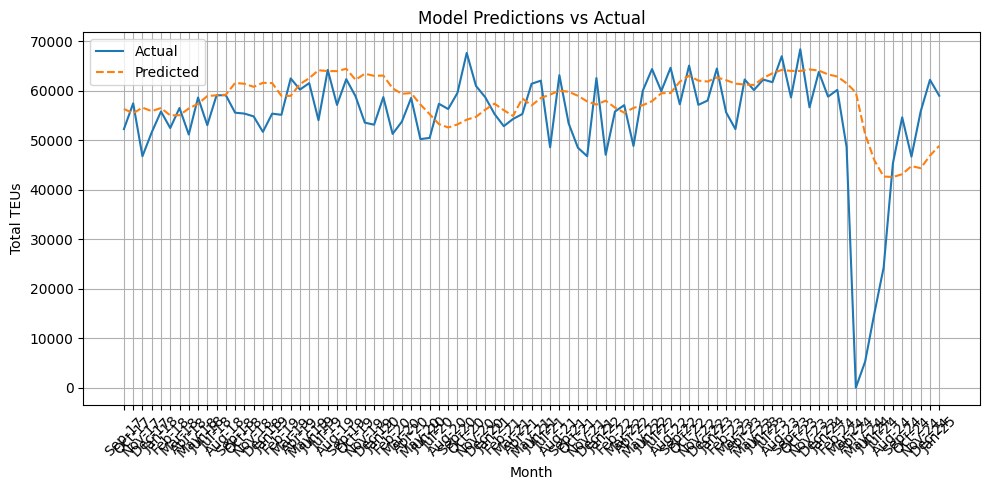


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                 10693.051
MSE              114341347.493
MAE                   6486.251
MAPE (%)       670359671062319.500
R²                       0.046
Adj R²                  -0.217
Training Time (s)           6.91
Memory Usage (MB)        1366.30
Peak Memory (MB)        3888.91
CPU Usage (%)            26.70
Device Used                CPU
---------------------------------------------------------------------------


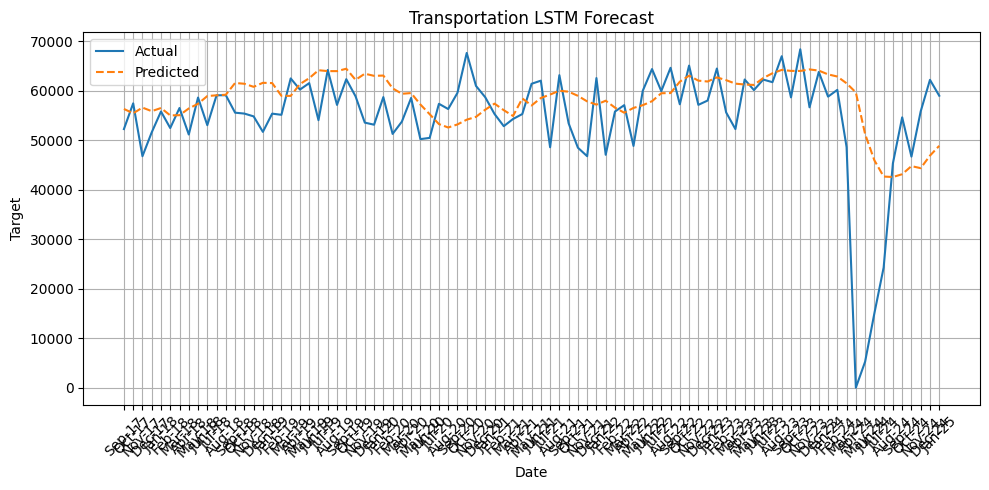

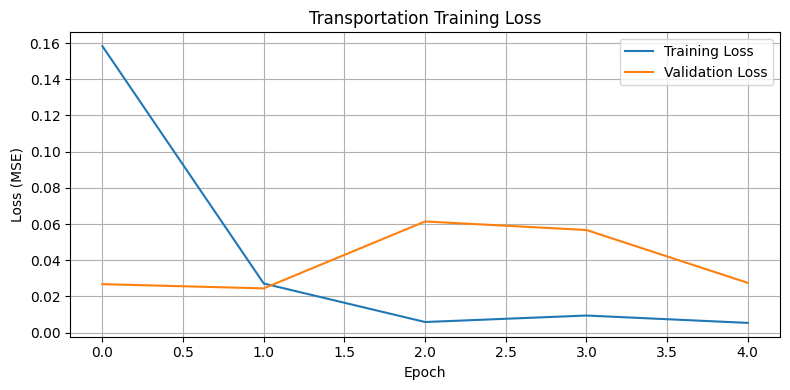

{'Dataset': 'Transportation',
 'RMSE': 10693.051364912388,
 'MSE': 114341347.49265467,
 'MAE': 6486.251350922502,
 'MAPE': 670359671062319.5,
 'R²': 0.045835423209148685,
 'Adj_R²': -0.21690554721152044,
 'TrainingTime': 6.905382394790649,
 'Device': 'CPU',
 'FinalMemoryMB': 1366.30078125,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 18.4,
 'TrainingLoss': 0.005378375295549631,
 'Model': 'LSTM'}

In [18]:
# Run LSTM Model on Transportation Data
data = transportation_data_no_lag
transportation_data_no_lag.name = "Transportation"
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

transportation_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
transportation_results

In [14]:
climate_data_no_lag = pd.read_csv('../data/dataset_climate/raw/Temperature Data of California.csv')

climate_data_no_lag

,County,TIME,Mean_Temperature
0,Alameda,1981-01,9.869529
1,Alameda,1981-02,11.723992
2,Alameda,1981-03,11.615960
3,Alameda,1981-04,14.036708
4,Alameda,1981-05,16.333115
...,...,...,...
30445,Yuba,2024-05,18.278763
30446,Yuba,2024-06,23.837745
30447,Yuba,2024-07,28.044864
30448,Yuba,2024-08,24.305265


[Before Training] Memory Usage: 1316.25 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.1498 - val_loss: 0.0245
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0276 - val_loss: 0.0223
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 9/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 10/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
[After Training] Memory U

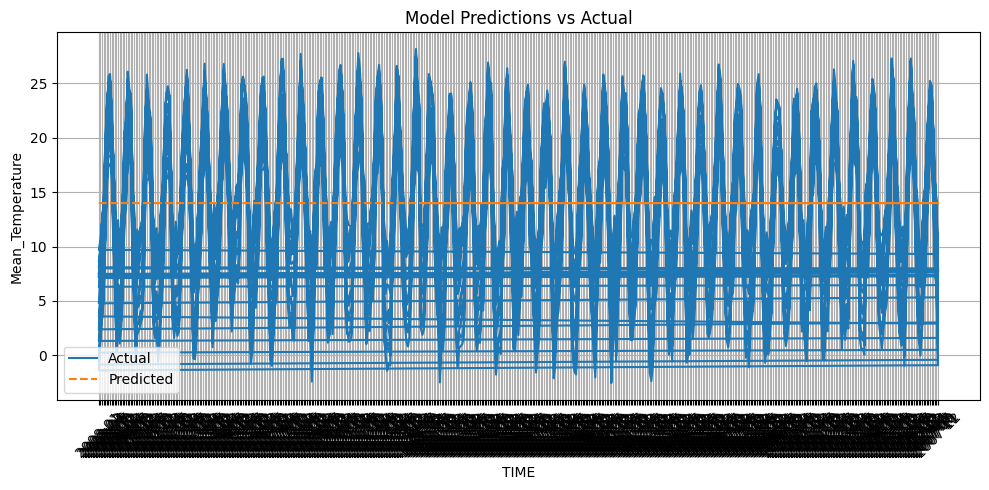


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                     6.344
MSE                     40.250
MAE                      5.346
MAPE (%)               154.069
R²                      -0.001
Adj R²                  -0.001
Training Time (s)         113.04
Memory Usage (MB)        1357.82
Peak Memory (MB)        3888.91
CPU Usage (%)            28.70
Device Used                CPU
---------------------------------------------------------------------------


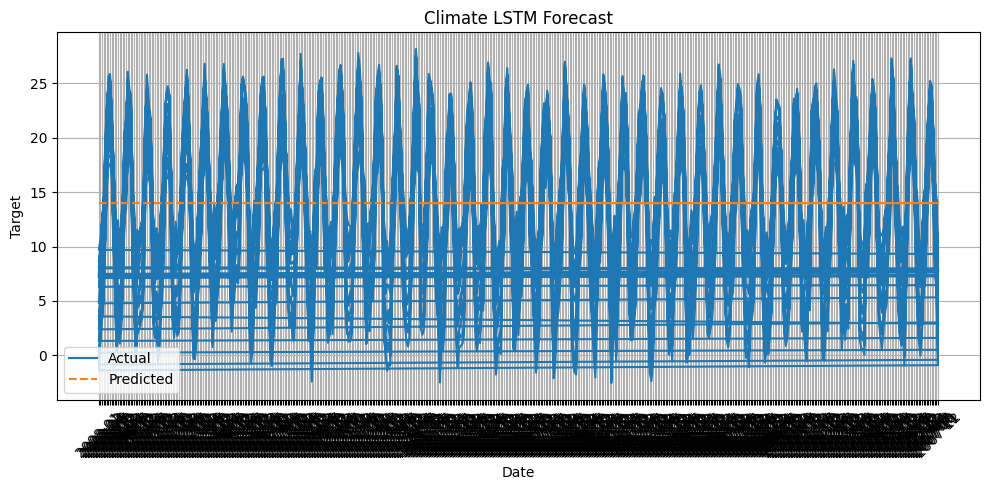

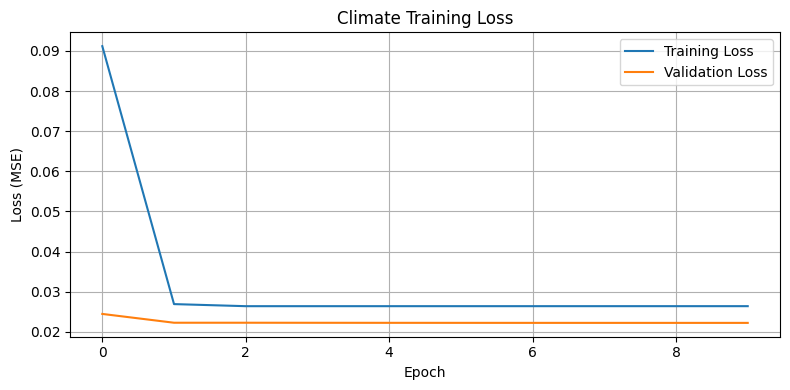

{'Dataset': 'Climate',
 'RMSE': 6.344307403603175,
 'MSE': 40.25023643141405,
 'MAE': 5.346144379169522,
 'MAPE': 154.06910086761965,
 'R²': -0.0011775777774991614,
 'Adj_R²': -0.0011775777774991614,
 'TrainingTime': 113.03892755508423,
 'Device': 'CPU',
 'FinalMemoryMB': 1357.8203125,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 15.2,
 'TrainingLoss': 0.026392502710223198,
 'Model': 'LSTM'}

In [15]:
# Run LSTM Model on Climate Data

# Define parameters for LSTM model
data = climate_data_no_lag
climate_data_no_lag.name = "Climate"
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

climate_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
climate_results

In [5]:
energy_data_no_lag = pd.read_csv('../data/dataset_energy/df_no_lag_indicators.csv')

energy_data_no_lag

,timestamp,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure
0,3/1/22 0:00,7294.03,4.370966,78.25,3.74,0.0,313.43,58.81,22,0
1,3/1/22 0:05,7304.76,4.507557,78.25,3.74,0.0,313.43,58.81,22,0
2,3/1/22 0:10,7176.53,4.476996,78.25,3.74,0.0,313.43,58.81,22,0
3,3/1/22 0:15,7247.72,4.497028,78.25,3.74,0.0,313.43,58.81,22,0
4,3/1/22 0:20,7169.96,4.478132,78.25,3.74,0.0,313.43,58.81,22,0
...,...,...,...,...,...,...,...,...,...,...
296679,31/12/24 23:40,7467.70,4.900523,74.58,3.40,0.0,202.82,73.07,22,0
296680,31/12/24 23:45,7393.27,4.967171,74.58,3.40,0.0,202.82,73.07,22,0
296681,31/12/24 23:50,7360.53,4.888091,74.58,3.40,0.0,202.82,73.07,22,0
296682,31/12/24 23:55,7345.74,4.894027,74.58,3.40,0.0,202.82,73.07,22,0


[Before Training] Memory Usage: 1105.31 MB | Peak Memory Usage: 1828.82 MB | CPU Usage: 0.00%
Epoch 1/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 2/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 3/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 4/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.0038 - val_loss: 0.0068
Epoch 5/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 6/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 7/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 8/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - loss: 0.0031 - val_loss: 0.0071
[After Training] Memory Usage: 1161.16 MB | Peak Memory Usage: 1828.82 MB | CPU Usage: 0.00%
Total Training Time: 739.00 seconds
Memory Used (MB): 55.84
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 15

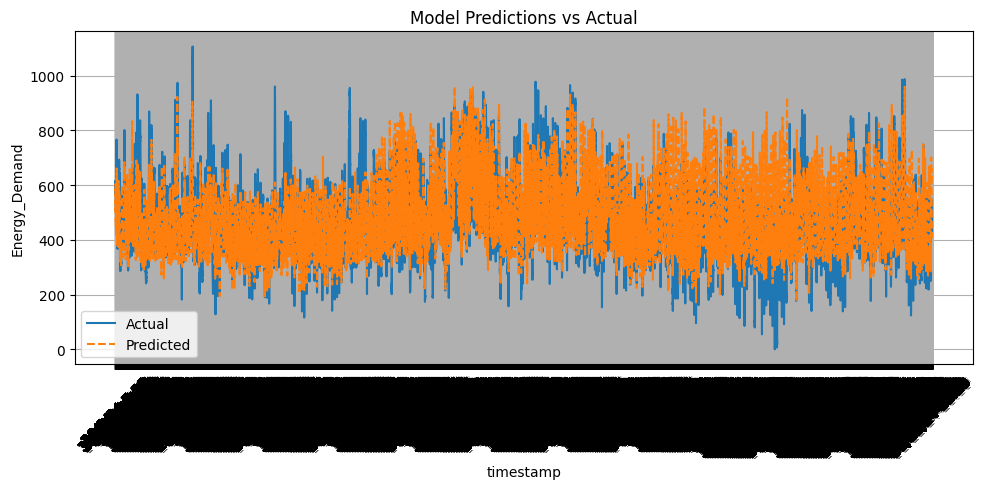


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                    90.786
MSE                   8242.103
MAE                     66.956
MAPE (%)        3610613929.852
R²                       0.590
Adj R²                   0.590
Training Time (s)         739.00
Memory Usage (MB)        3447.70
Peak Memory (MB)        3499.88
CPU Usage (%)            24.70
Device Used                CPU
---------------------------------------------------------------------------


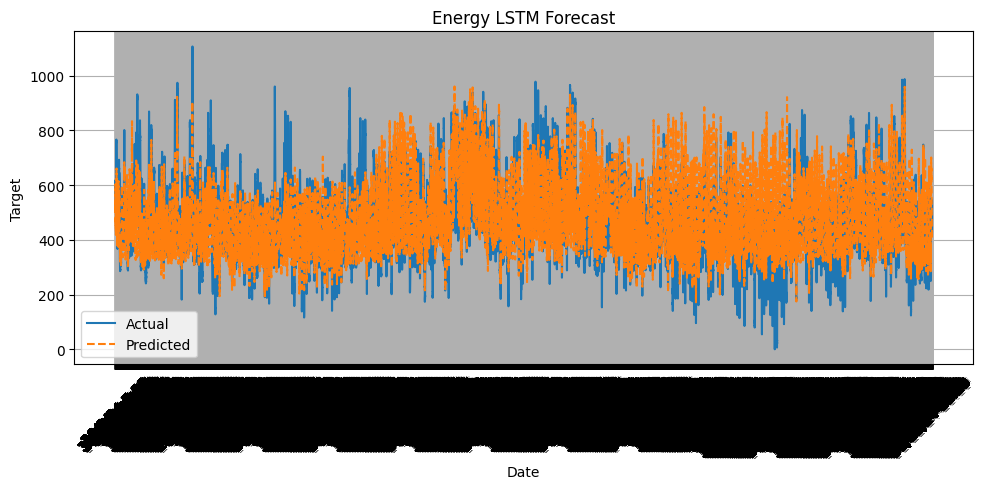

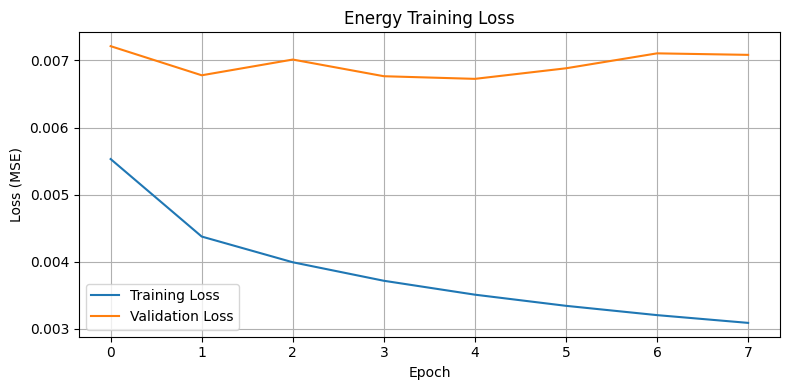

{'Dataset': 'Energy',
 'RMSE': 90.78603126341899,
 'MSE': 8242.10347256249,
 'MAE': 66.95624479989564,
 'MAPE': 3610613929.8520656,
 'R²': 0.5898467515220028,
 'Adj_R²': 0.5898098788426772,
 'TrainingTime': 739.0022518634796,
 'Device': 'CPU',
 'FinalMemoryMB': 3447.69140625,
 'PeakMemoryMB': 3499.875,
 'CPUUsage': 17.5,
 'TrainingLoss': 0.0030906079337000847,
 'Model': 'LSTM'}

In [6]:
# Run LSTM Model on Energy Data

# Define parameters for LSTM model
data = energy_data_no_lag
energy_data_no_lag.name = "Energy"
target = 'Energy_Demand'  # Target variable to predict
date_col = 'timestamp'  # Column name for the date
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

energy_results = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
energy_results

Metrics collected and saved to:
outputs/results/output_LSTM/model_metrics_scores.csv
                        RMSE           MSE          MAE          MAPE  \
Dataset                                                                 
Finance             0.549305  3.017364e-01     0.425730  2.870168e+00   
Retail              0.132962  1.767900e-02     0.107012  4.102408e+01   
Climate             6.344307  4.025024e+01     5.346144  1.540691e+02   
Energy             90.786031  8.242103e+03    66.956245  3.610614e+09   
Transportation  10693.051365  1.143413e+08  6486.251351  6.703597e+14   

                      R²    Adj_R²  TrainingTime Device  FinalMemoryMB  \
Dataset                                                                  
Finance         0.846869  0.831818     10.572094    CPU     564.085938   
Retail          0.170098  0.155978     14.621218    CPU    1335.804688   
Climate        -0.001178 -0.001178    113.038928    CPU    1357.820312   
Energy          0.589847  0.58981

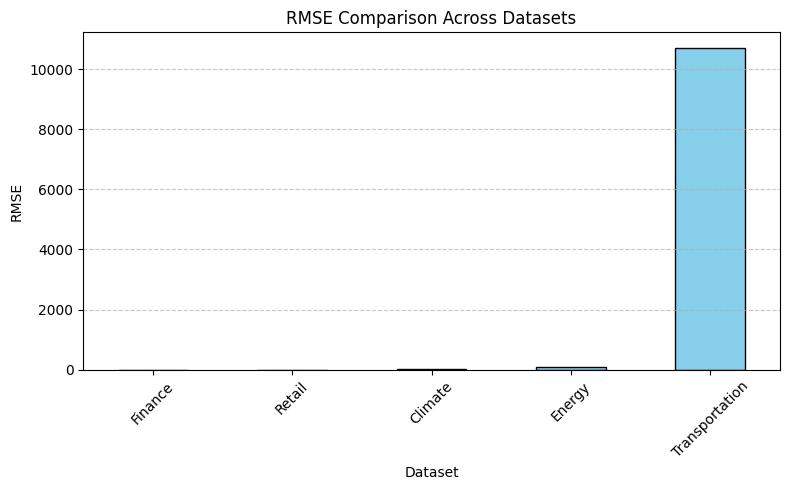

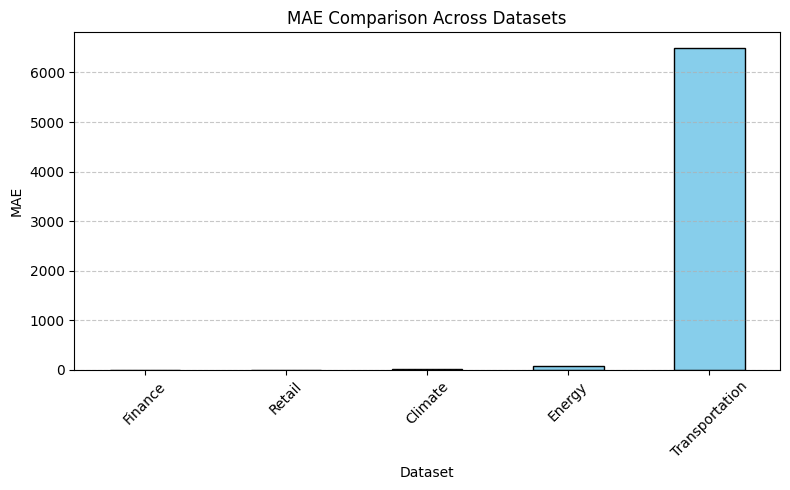

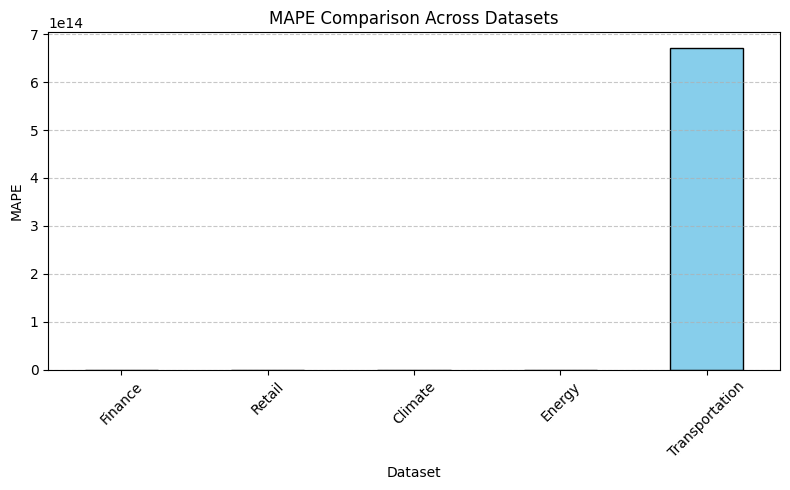

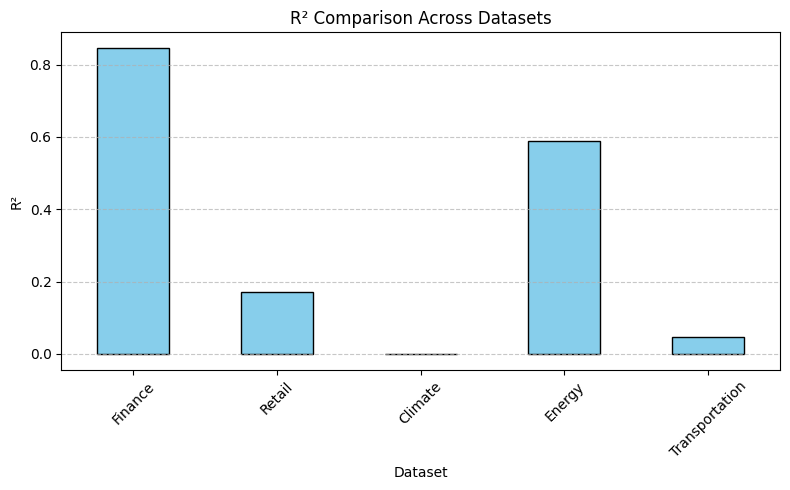

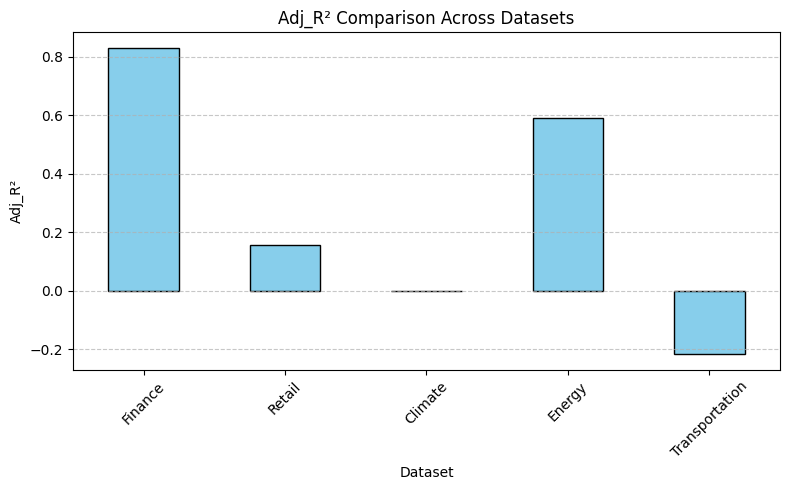

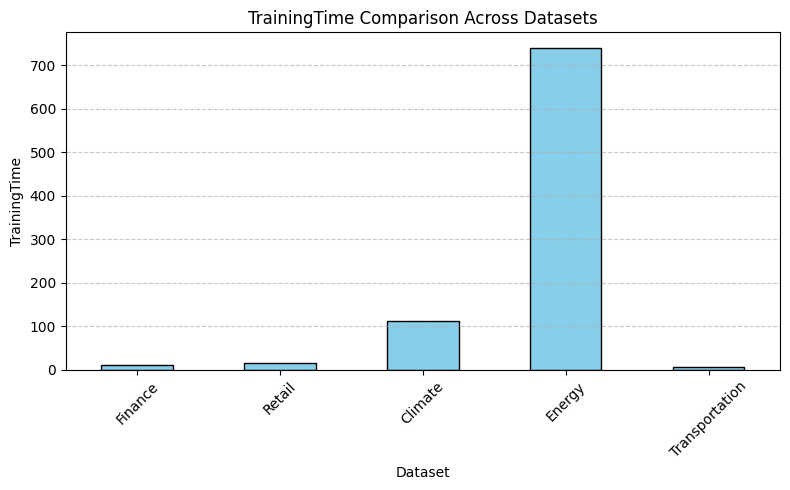

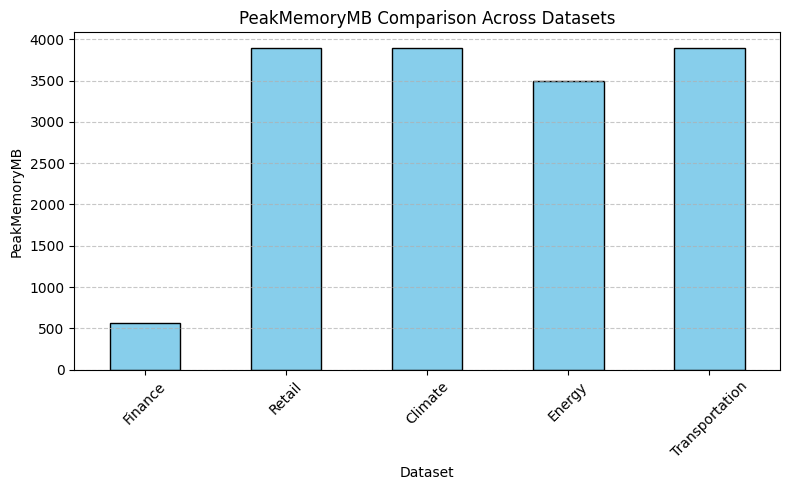

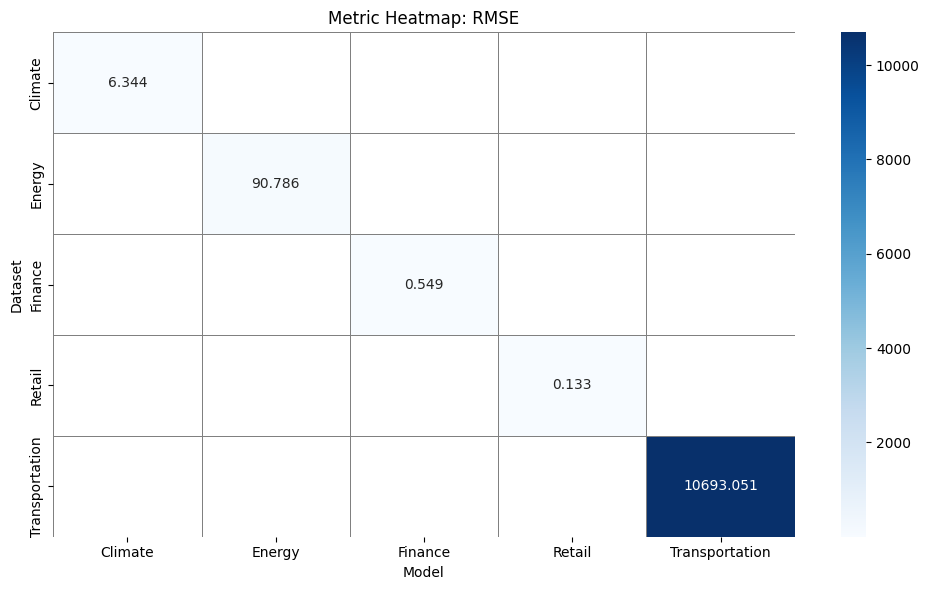

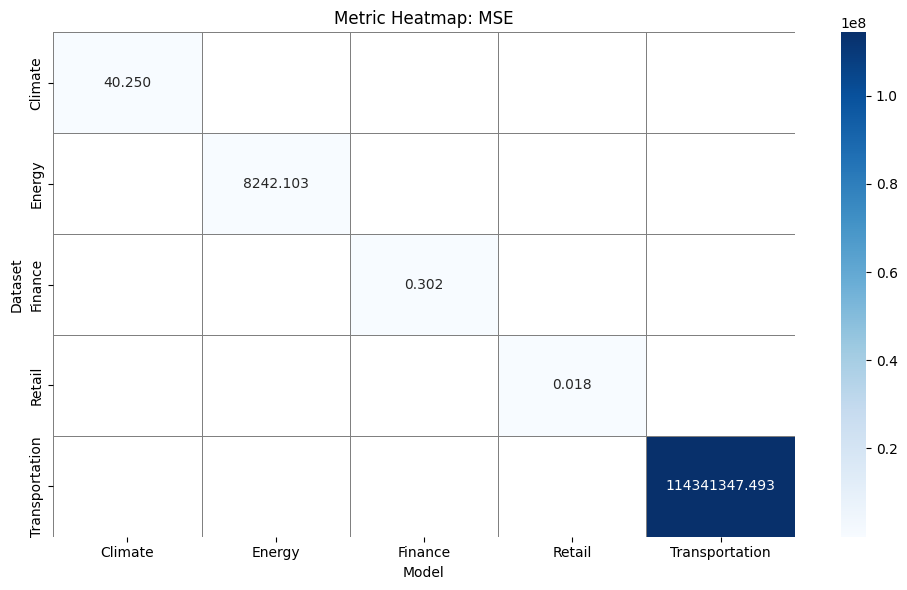

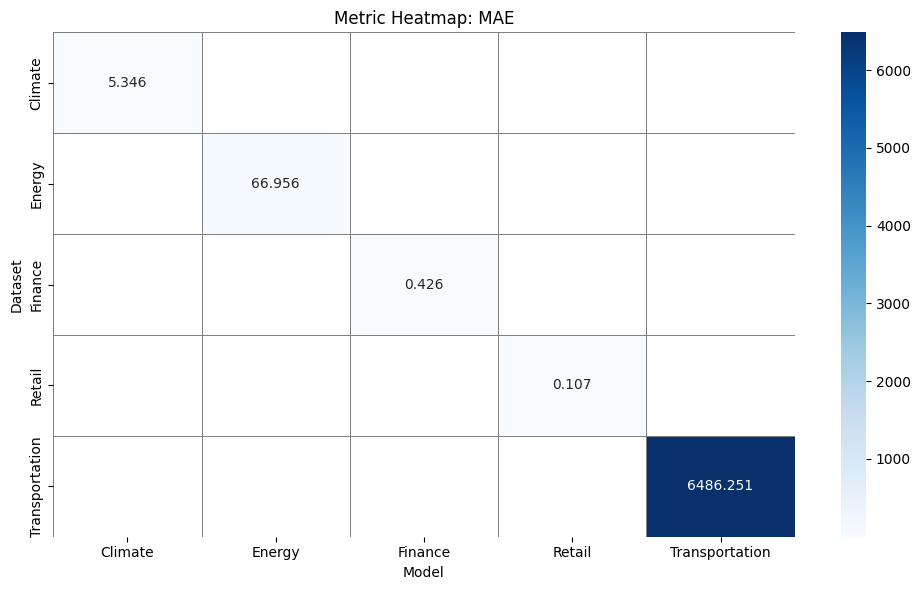

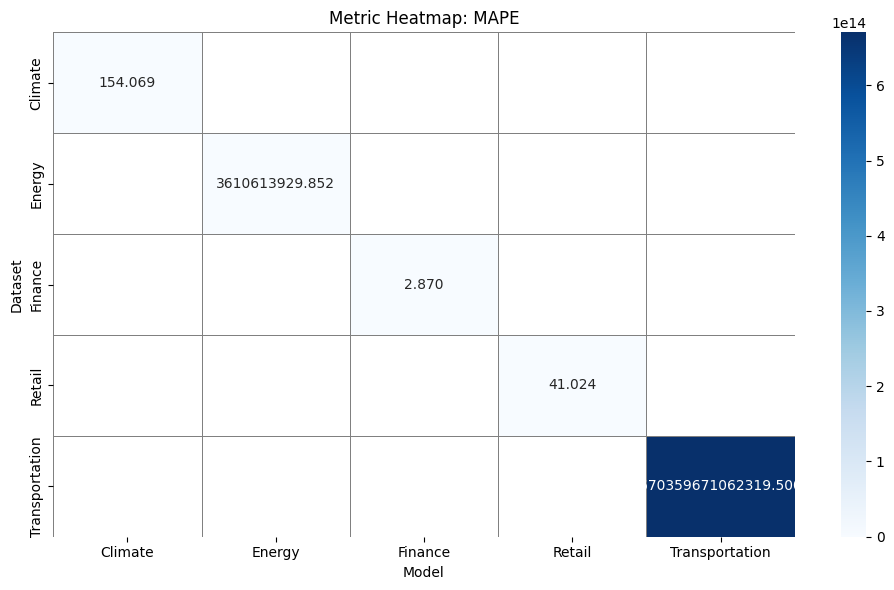

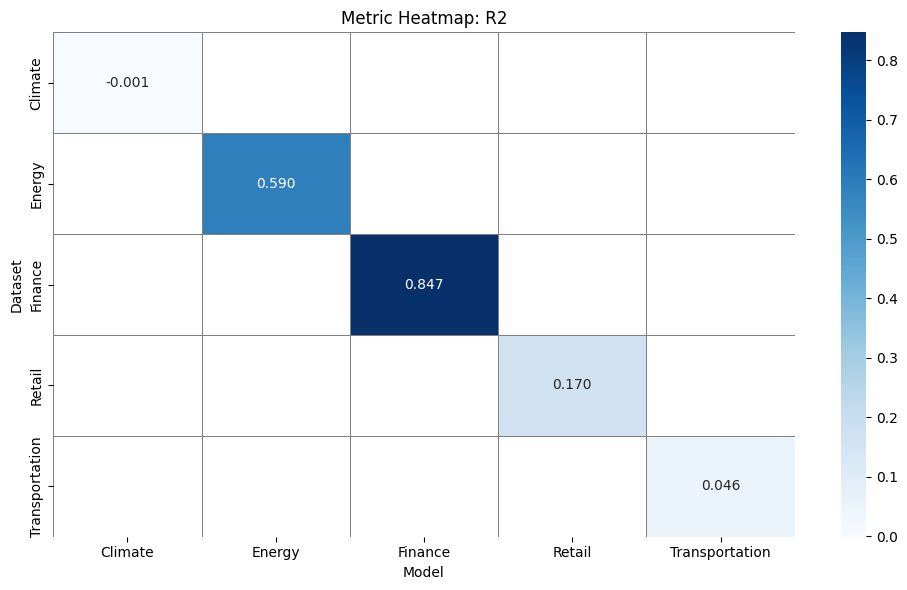

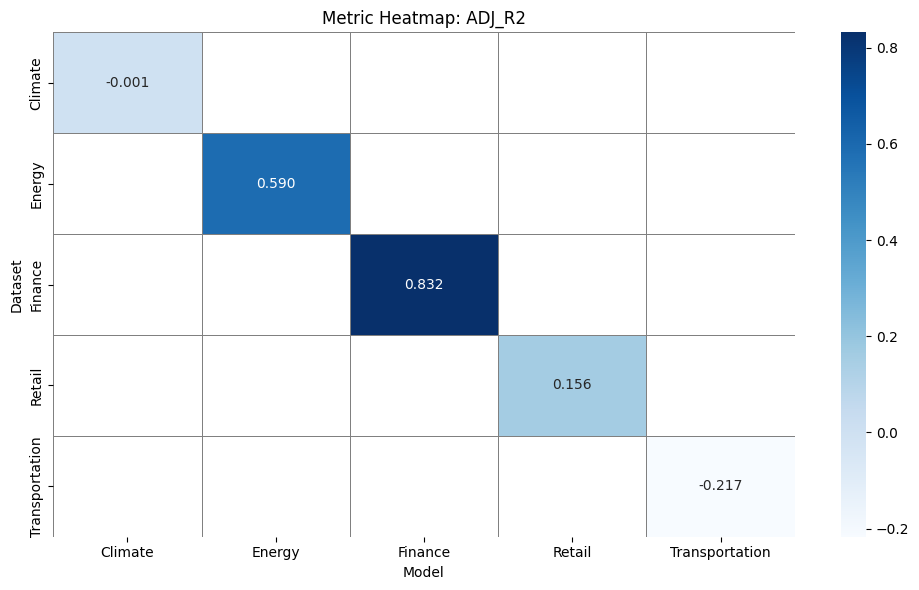

In [19]:
# Step 1: Collect all result dictionaries
all_results = [
    finance_results,
    retail_results,
    climate_results,
    energy_results,
    transportation_results
]

# Step 2: Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df.set_index('Dataset', inplace=True)

# Step 3: Save to CSV
output_path = "outputs/results/output_LSTM/model_metrics_scores.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metrics_df.to_csv(output_path)

# Step 4: Display
print(f"Metrics collected and saved to:\n{output_path}")
print(metrics_df)

#	Step 5: Plotting

# Load the metrics CSV if it exists
metrics_path = "outputs/results/output_LSTM/model_metrics_scores.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df.set_index('Dataset', inplace=True)

# Plot comparison charts for each metric
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R²", "Adj_R²", "TrainingTime", "PeakMemoryMB"]
figures = {}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    fig_path = f"outputs/results/output_LSTM/{metric}_comparison.png"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.savefig(fig_path)
    figures[metric] = fig_path
    
    # Show the figure
    plt.show()

figures

# Step 6: Standardize metric column names
metrics_df.rename(columns={
    'RMSE': 'rmse',
    'MSE': 'mse',
    'MAE': 'mae',
    'MAPE': 'mape',
    'R²': 'r2',
    'Adj_R²': 'adj_r2'
}, inplace=True)

# Optional: add model name column if needed
if 'model_name' not in metrics_df.columns:
    metrics_df['model_name'] = metrics_df.index

# Step 7: Heatmaps by Dataset (rows) × model_name (columns)
plot_heatmap(metrics_df.reset_index())

#### Univariate Input Single Output

[Before Training] Memory Usage: 1362.91 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0280 - val_loss: 0.3157
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0239 - val_loss: 0.2890
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0230 - val_loss: 0.2792
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - val_loss: 0.2767
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0229 - val_loss: 0.2762
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0229 - val_loss: 0.2762
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - val_loss: 0.2762
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - val_loss: 0.2762
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - val_loss: 0.2762
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0229 - val_loss: 0.2762
[After Training] Memory Usage: 1377.87 MB | Peak Memory

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


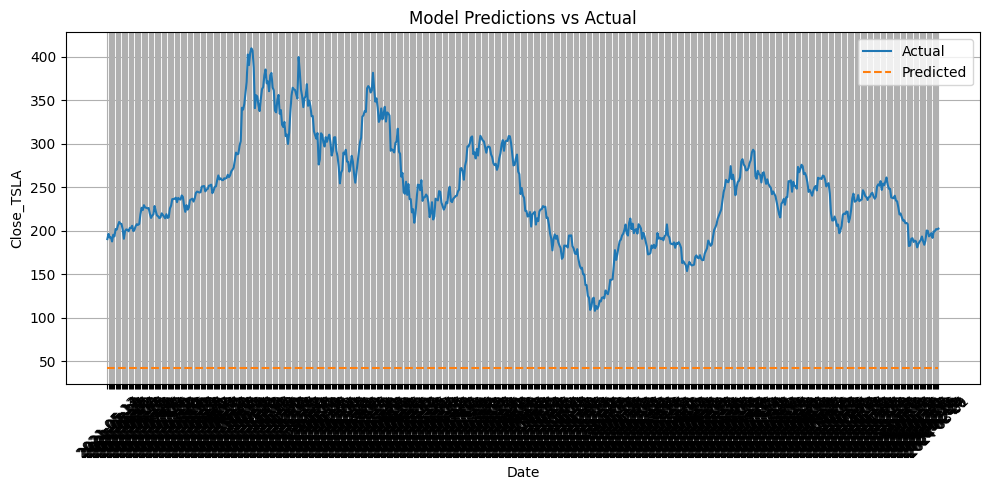


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                   210.408
MSE                  44271.348
MAE                    202.362
MAPE (%)                81.661
R²                     -12.331
Adj R²                 -12.331
Training Time (s)          15.98
Memory Usage (MB)        1382.62
Peak Memory (MB)        3888.91
CPU Usage (%)            24.40
Device Used                CPU
---------------------------------------------------------------------------


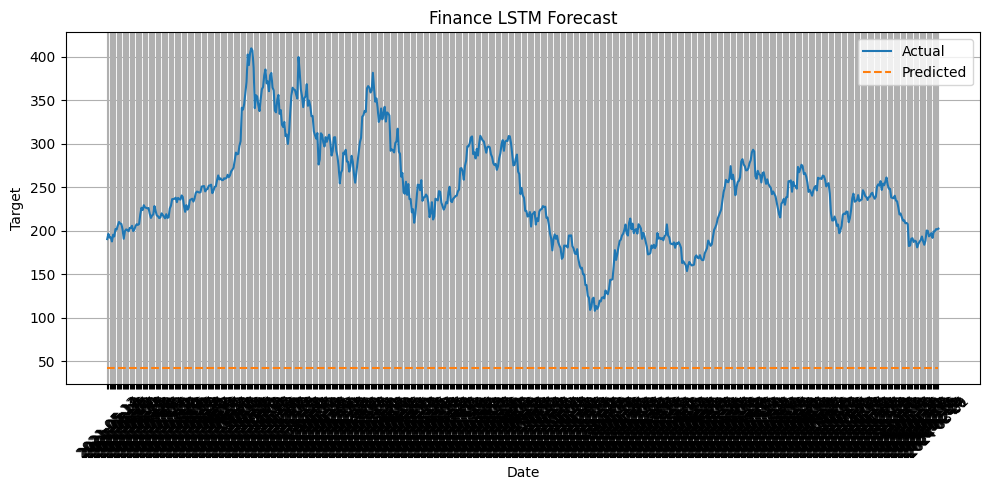

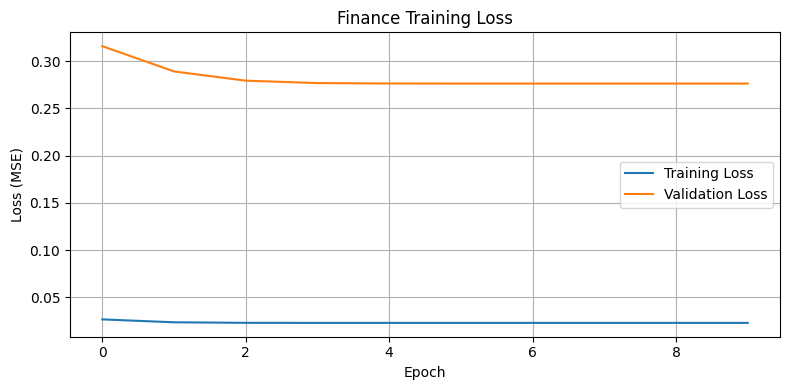

{'Dataset': 'Finance',
 'RMSE': 210.40757697342465,
 'MSE': 44271.348447827615,
 'MAE': 202.36212422977266,
 'MAPE': 81.66092932946673,
 'R²': -12.331052874487561,
 'Adj_R²': -12.331052874487561,
 'TrainingTime': 15.983423709869385,
 'Device': 'CPU',
 'FinalMemoryMB': 1382.6171875,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 14.3,
 'TrainingLoss': 0.023146742954850197,
 'Model': 'LSTM'}

In [20]:
# Run LSTM Model on Finance Data

# Define parameters for LSTM model
target = 'Close_TSLA'  # Target variable to predict
date_col = 'Date'  # Column name for the date
data = finance_data_no_lag[[target, date_col]]
data.name = "Finance"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

finance_results_1 = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
finance_results_1

[Before Training] Memory Usage: 1380.48 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1286 - val_loss: 0.1490
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1047 - val_loss: 0.1240
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0849 - val_loss: 0.1032
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0689 - val_loss: 0.0861
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0562 - val_loss: 0.0723
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0463 - val_loss: 0.0613
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0388 - val_loss: 0.0527
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0332 - val_loss: 0.0460
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0291 - val_loss: 0.0408
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0262 - val_loss: 0.0369
[After Training] Memory Usage: 1384.18 MB | Peak Memory

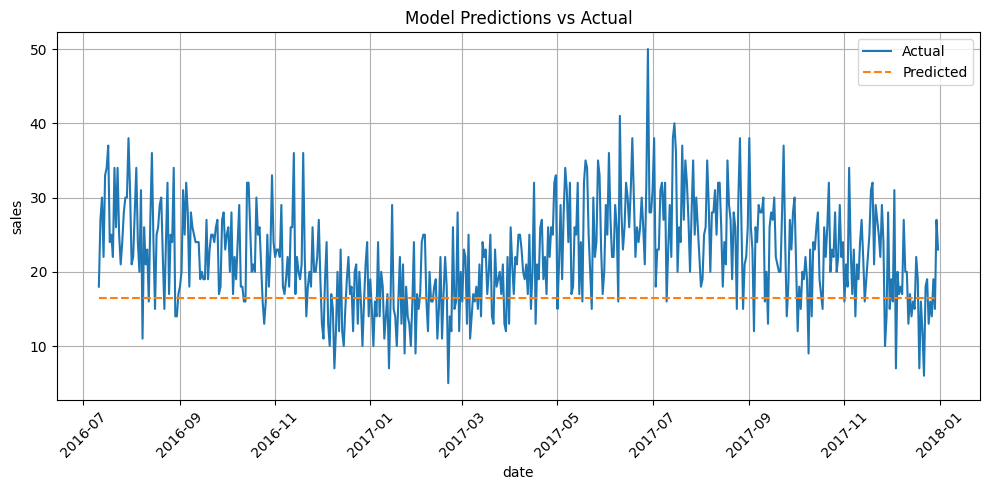


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                     8.834
MSE                     78.037
MAE                      7.038
MAPE (%)                29.799
R²                      -0.731
Adj R²                  -0.731
Training Time (s)          13.64
Memory Usage (MB)        1386.31
Peak Memory (MB)        3888.91
CPU Usage (%)            21.90
Device Used                CPU
---------------------------------------------------------------------------


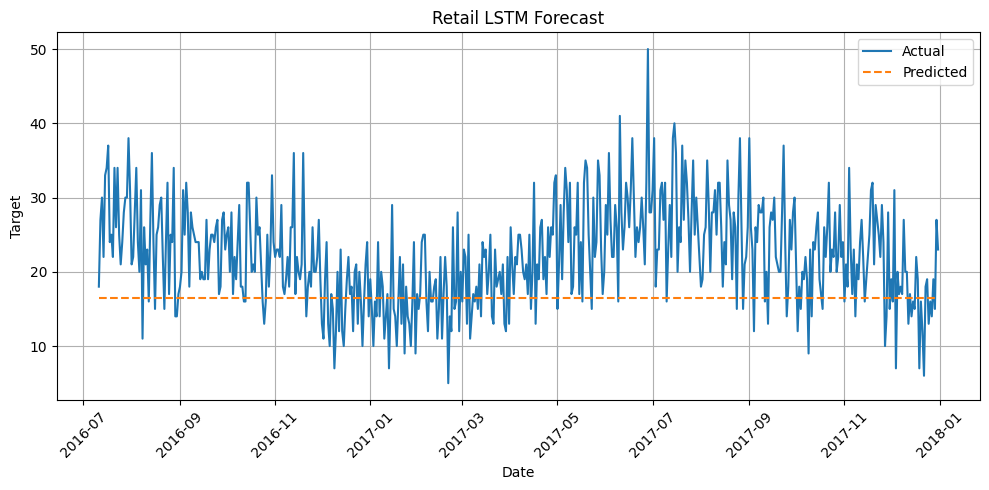

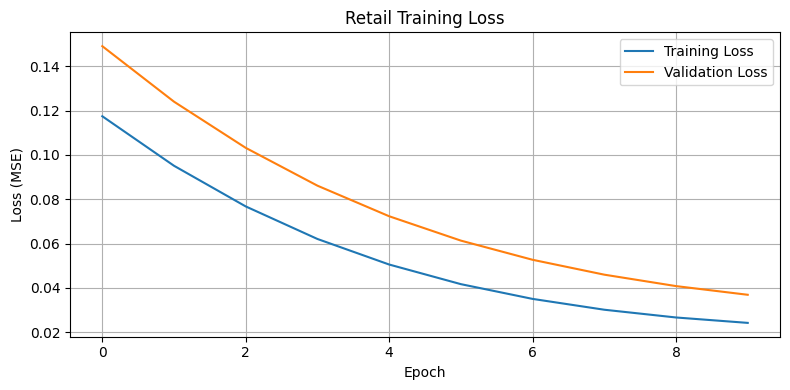

{'Dataset': 'Retail',
 'RMSE': 8.833837387086536,
 'MSE': 78.03668298148787,
 'MAE': 7.037822188826793,
 'MAPE': 29.798570522696345,
 'R²': -0.7312213062043857,
 'Adj_R²': -0.7312213062043857,
 'TrainingTime': 13.643999576568604,
 'Device': 'CPU',
 'FinalMemoryMB': 1386.30859375,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 14.1,
 'TrainingLoss': 0.02420077845454216,
 'Model': 'LSTM'}

In [21]:
# Run LSTM Model on Retail Data

# Define parameters for LSTM model
target = 'sales'  # Target variable to predict
date_col = 'date'  # Column name for the date
data = retail_data_no_lag[[target, date_col]]
data.name = "Retail"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

retail_results_1 = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
retail_results_1

[Before Training] Memory Usage: 1382.57 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.2691 - val_loss: 0.6577
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2621 - val_loss: 0.6467
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2552 - val_loss: 0.6358
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2484 - val_loss: 0.6250
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2418 - val_loss: 0.6144
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2352 - val_loss: 0.6040
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2289 - val_loss: 0.5937
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2226 - val_loss: 0.5836
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2165 - val_loss: 0.5736
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2105 - val_loss: 0.5638
[After Training] Memory Usage: 1393.74 MB | Peak Memory Usage: 3888.91 MB 

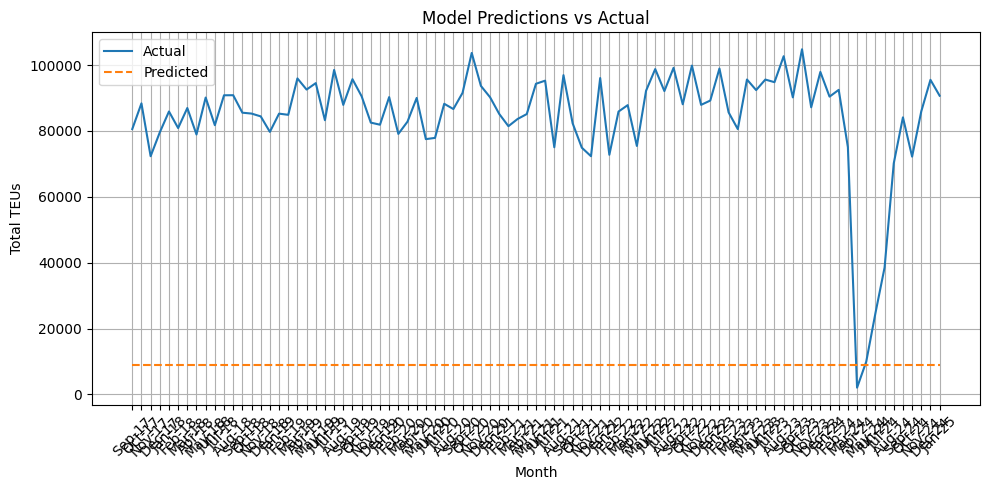


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                 77167.398
MSE             5954807369.658
MAE                  75551.218
MAPE (%)                91.030
R²                     -21.001
Adj R²                 -21.001
Training Time (s)           8.66
Memory Usage (MB)        1396.59
Peak Memory (MB)        3888.91
CPU Usage (%)            27.90
Device Used                CPU
---------------------------------------------------------------------------


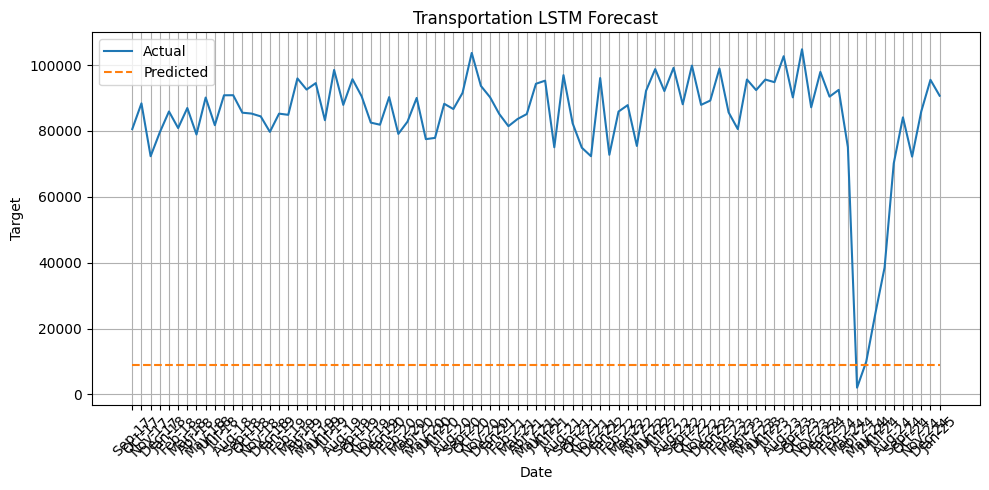

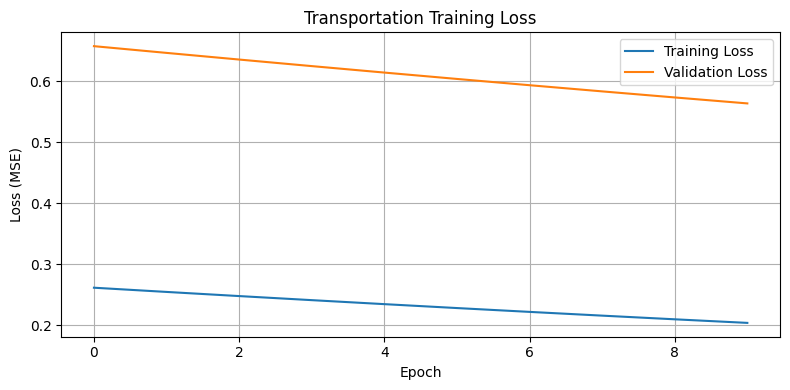

{'Dataset': 'Transportation',
 'RMSE': 77167.39836004759,
 'MSE': 5954807369.658275,
 'MAE': 75551.21824052629,
 'MAPE': 91.03000932233675,
 'R²': -21.000803196342392,
 'Adj_R²': -21.000803196342392,
 'TrainingTime': 8.664445400238037,
 'Device': 'CPU',
 'FinalMemoryMB': 1396.59375,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 34.5,
 'TrainingLoss': 0.20390060544013977,
 'Model': 'LSTM'}

In [22]:
# Run LSTM Model on Transportation Data
target = 'Total TEUs'
date_col = 'Month'  # Column name for the date
data = transportation_data_no_lag[[target, date_col]]
data.name = "Transportation"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

transportation_results_1 = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
transportation_results_1

[Before Training] Memory Usage: 1393.77 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.1498 - val_loss: 0.0245
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0276 - val_loss: 0.0223
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 9/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0264 - val_loss: 0.0222
Epoch 10/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0264 - val_loss: 0.0222
[After Training] Memory U

286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


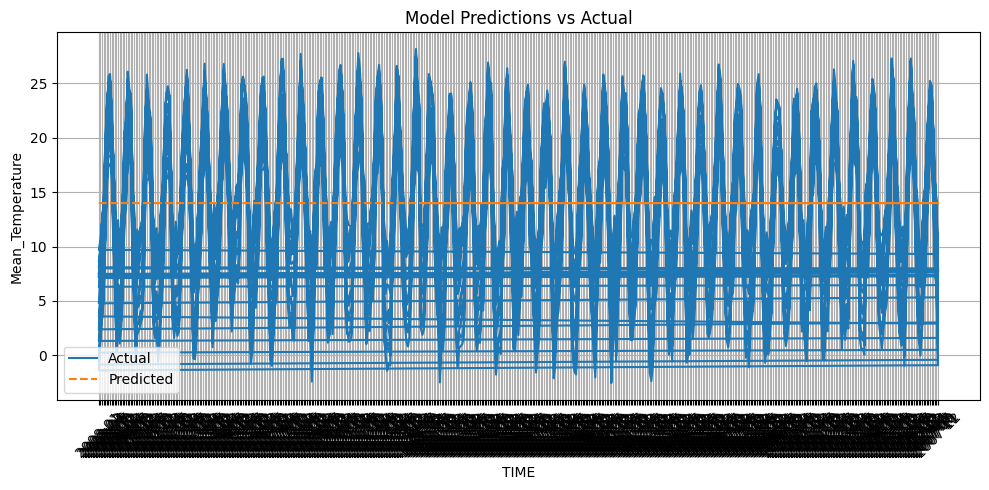


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                     6.344
MSE                     40.250
MAE                      5.346
MAPE (%)               154.069
R²                      -0.001
Adj R²                  -0.001
Training Time (s)         115.10
Memory Usage (MB)        1430.43
Peak Memory (MB)        3888.91
CPU Usage (%)            22.30
Device Used                CPU
---------------------------------------------------------------------------


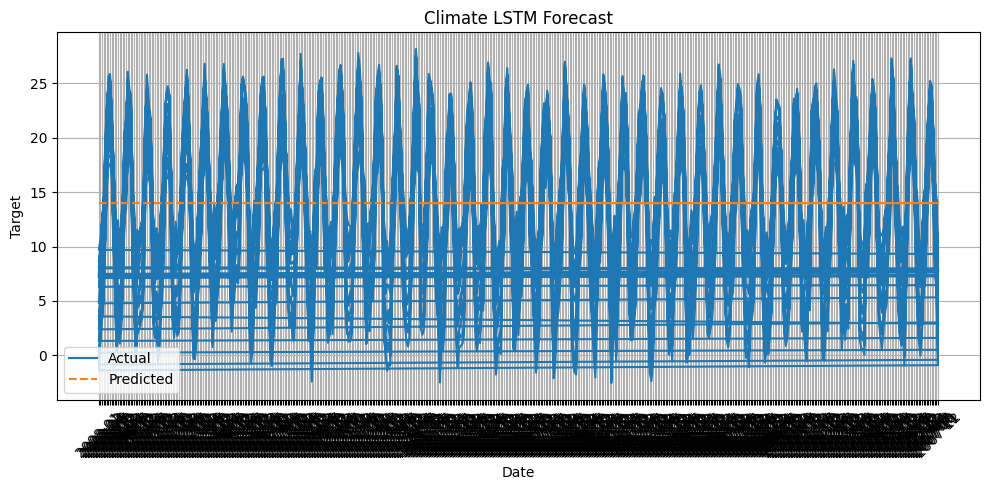

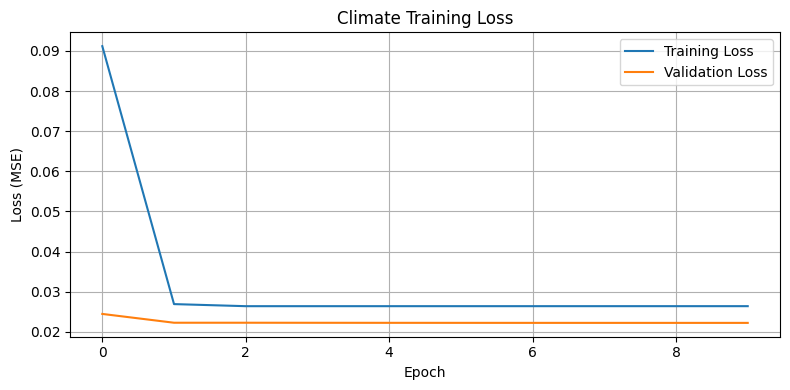

{'Dataset': 'Climate',
 'RMSE': 6.344307403603175,
 'MSE': 40.25023643141405,
 'MAE': 5.346144379169522,
 'MAPE': 154.06910086761965,
 'R²': -0.0011775777774991614,
 'Adj_R²': -0.0011775777774991614,
 'TrainingTime': 115.09971928596497,
 'Device': 'CPU',
 'FinalMemoryMB': 1430.4296875,
 'PeakMemoryMB': 3888.91015625,
 'CPUUsage': 15.5,
 'TrainingLoss': 0.026392502710223198,
 'Model': 'LSTM'}

In [23]:
# Run LSTM Model on Climate Data

# Define parameters for LSTM model
target = 'Mean_Temperature'
date_col = 'TIME'  # Column name for the date
data = climate_data_no_lag[[target, date_col]]
data.name = "Climate"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

climate_results_1 = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
climate_results_1

[Before Training] Memory Usage: 693.81 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Epoch 1/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 122s 18ms/step - loss: 0.0346 - val_loss: 0.0164
Epoch 2/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 3/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 112s 17ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 4/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 116s 18ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 5/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 99s 15ms/step - loss: 0.0147 - val_loss: 0.0164
Epoch 6/10
6490/6490 ━━━━━━━━━━━━━━━━━━━━ 102s 16ms/step - loss: 0.0147 - val_loss: 0.0164
[After Training] Memory Usage: 672.23 MB | Peak Memory Usage: 3888.91 MB | CPU Usage: 0.00%
Total Training Time: 655.47 seconds
Memory Used (MB): -21.58
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


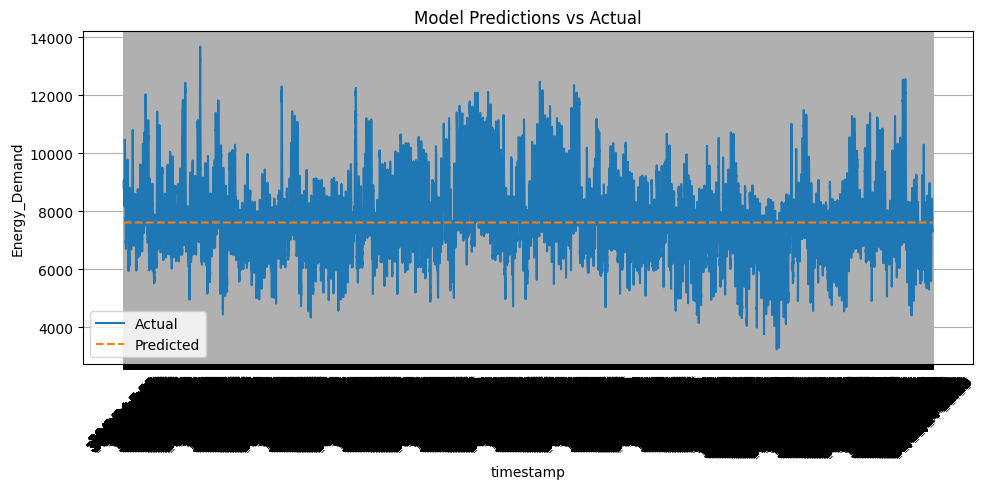


Evaluation Summary
---------------------------------------------------------------------------
Metric                   Value
---------------------------------------------------------------------------
RMSE                  1337.241
MSE                1788212.336
MAE                   1045.053
MAPE (%)                13.853
R²                      -0.001
Adj R²                  -0.001
Training Time (s)         655.47
Memory Usage (MB)        2706.69
Peak Memory (MB)        3888.91
CPU Usage (%)            21.70
Device Used                CPU
---------------------------------------------------------------------------


KeyboardInterrupt: 

In [7]:
# Run LSTM Model on Energy Data

# Define parameters for LSTM model
target = 'Energy_Demand'  # Target variable to predict
date_col = 'timestamp'  # Column name for the date
data = energy_data_no_lag[[target, date_col]]
data.name = "Energy"
seq_length = 30  # Number of time steps to look back
test_ratio = 0.3  # Proportion of data to use for testing
epochs = 10  # Number of epochs for training
batch_size = 32  # Batch size for training

energy_results_1 = run_lstm_on_dataset(data, target, date_col, seq_length, test_ratio, epochs, batch_size)
energy_results_1

In [26]:
# Step 1: Collect all result dictionaries
all_results = [
    finance_results_1,
    retail_results_1,
    climate_results_1,
    energy_results_1,
    transportation_results_1
]

# Step 2: Convert to DataFrame
metrics_df = pd.DataFrame(all_results)
metrics_df.set_index('Dataset', inplace=True)

# Step 3: Save to CSV
output_path = "outputs/results/output_LSTM/model_metrics_scores_1.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
metrics_df.to_csv(output_path)

# Step 4: Display
print(f"Metrics collected and saved to:\n{output_path}")
print(metrics_df)

#	Step 5: Plotting

# Load the metrics CSV if it exists
metrics_path = "outputs/results/output_LSTM/model_metrics_scores_1.csv"
metrics_df = pd.read_csv(metrics_path)
metrics_df.set_index('Dataset', inplace=True)

# Plot comparison charts for each metric
metrics_to_plot = ["RMSE", "MAE", "MAPE", "R²", "Adj_R²", "TrainingTime", "FinalMemoryMB"]
figures = {}

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    metrics_df[metric].plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"{metric} Comparison Across Datasets")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the figure
    fig_path = f"outputs/results/output_LSTM/{metric}_comparison_1.png"
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.savefig(fig_path)
    figures[metric] = fig_path
    
    # Show the figure
    plt.show()

figures

# Step 6: Standardize metric column names
metrics_df.rename(columns={
    'RMSE': 'rmse',
    'MSE': 'mse',
    'MAE': 'mae',
    'MAPE': 'mape',
    'R²': 'r2',
    'Adj_R²': 'adj_r2'
}, inplace=True)

# Optional: add model name column if needed
if 'model_name' not in metrics_df.columns:
    metrics_df['model_name'] = metrics_df.index

# Step 7: Heatmaps by Dataset (rows) × model_name (columns)
plot_heatmap(metrics_df.reset_index())

NameError: name 'energy_results_1' is not defined

In [ ]:
# import os
# import sys
# import importlib

# # Add one level up to sys.path if not already added
# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# # First, import the full module (not just the function)
# import src.models.DL_LSTM

# # Now reload it
# importlib.reload(src.models.DL_LSTM)

# # Re-import the specific function you want (after reload)
# from src.models.DL_LSTM import run_lstm_on_dataset, log_system_usage, evaluate_predictions, plot_predictions


In [25]:
import gc
gc.collect()

import tensorflow as tf
tf.keras.backend.clear_session()